In [1]:
from PIL import Image
import os

def process_images(main_folder_path, output_folder):
    for subfolder in os.listdir(main_folder_path):
        subfolder_path = os.path.join(main_folder_path, subfolder)

        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith(".png"):
                    image_path = os.path.join(subfolder_path, filename)

                    # Open the image using PIL
                    img = Image.open(image_path)

                    # Perform image processing tasks, for example, resize
                    new_size = (100, 100)
                    resized_img = img.resize(new_size)

                    # Save the processed image to the output folder
                    output_path = os.path.join(output_folder, subfolder, filename)
                    os.makedirs(os.path.dirname(output_path), exist_ok=True)
                    resized_img.save(output_path)

                    # Print the file name for demonstration
                    print(f"Processing and saving: {filename}")

if __name__ == "__main__":
    # Provide the path to the main folder containing subfolders with ECG images
    main_folder_path = r"C:\Users\omhee\Downloads\archive (5)"


    # Provide the path to the output folder where processed images will be saved
    output_folder_path = r"C:\Users\omhee\OneDrive\Desktop\processed images"

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder_path, exist_ok=True)

    process_images(main_folder_path, output_folder_path)


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
BATCH_SIZE = 128
IM_SHAPE = (224,224,3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

In [4]:
ecg_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\omhee\OneDrive\Desktop\processed images",   
    image_size=(IM_SHAPE[0], IM_SHAPE[1]), 
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 24764 files belonging to 6 classes.


In [5]:
ecg_test_dataset.class_names

['F', 'M', 'N', 'Q', 'S', 'V']

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 2

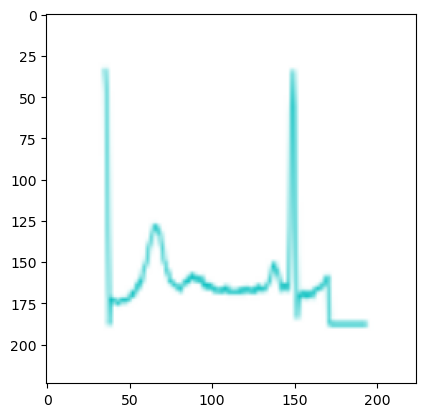

In [6]:
for x in ecg_test_dataset.unbatch():
    plt.imshow(x[0]/255)
    print(x)
    break

# DATA AUGEMENTATION 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(input_folder, output_folder, num_augmented_images=5):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for filename in os.listdir(input_folder):
        if filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)

            # Open the image using PIL
            img = Image.open(image_path)
            img_array = np.array(img)
            img_array = img_array.reshape((1,) + img_array.shape)

            # Generate augmented images
            for i, batch in enumerate(datagen.flow(img_array, batch_size=1, save_to_dir=output_folder, save_prefix=filename[:-4], save_format='png')):
                if i >= num_augmented_images:
                    break

            # Print the file name for demonstration
            print(f"Data augmentation for: {filename}")

# Example usage
input_folder_path = r"C:\Users\omhee\Downloads\archive (5)\ECG_Image_data"
output_folder_path =  r"C:\Users\omhee\OneDrive\Desktop\processed images"
augment_data(input_folder_path, output_folder_path)


# NORMALIZATION

In [8]:
from PIL import Image
import os
import numpy as np

def normalize_images(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)

            # Open the image using PIL
            img = Image.open(image_path)

            # Normalization
            img_normalized = img.point(lambda x: x / 255.0)

            # Save the processed image to the output folder
            output_path = os.path.join(output_folder, filename)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            img_normalized.save(output_path)

            # Print the file name for demonstration
            print(f"Normalization and saving: {filename}")

# Example usage
input_folder_path = r"C:\Users\omhee\Downloads\archive (5)\ECG_Image_data"
output_folder_path = r"C:\Users\omhee\OneDrive\Desktop\processed images"
normalize_images(input_folder_path, output_folder_path)


In [9]:
def preprocess_images(image, label):
    new_label = tf.where(label == 2, 0, 1)
    new_image = tf.cast(image, tf.float32) / 255.0
    return new_image, new_label

In [10]:
ecg_test_dataset = ecg_test_dataset.map(preprocess_images)

In [11]:
ecg_test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
import random
def separate_normal_and_abnormal(ds):
    normal_images = []
    abnormal_images = []
    for batch in ds:
        images,labels = batch
        for image,label in zip(images,labels):
            if label.numpy() == 0:
                normal_images.append(image.numpy())
            else:
                abnormal_images.append(image.numpy())
    random.shuffle(normal_images)
    random.shuffle(abnormal_images)
    return normal_images,abnormal_images

# grayscale_images

In [13]:
from PIL import Image
import os
import numpy as np

def grayscale_images(main_folder_path, output_folder_path):
    for subfolder in os.listdir(main_folder_path):
        subfolder_path = os.path.join(main_folder_path, subfolder)

        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith(".png"):
                    image_path = os.path.join(subfolder_path, filename)

                    # Open the image using PIL
                    img = Image.open(image_path)

                    # Convert the image to grayscale
                    grayscale_img = img.convert('L')

                    # Save the grayscale image to the output folder
                    output_path = os.path.join(output_folder_path, subfolder, filename)
                    os.makedirs(os.path.dirname(output_path), exist_ok=True)
                    grayscale_img.save(output_path)

                    # Print the file name for demonstration
                    print(f"Grayscaling and saving: {filename}")

if __name__ == "__main__":
    # Provide the path to the main folder containing subfolders with ECG images
    main_folder_path = r"C:\Users\omhee\OneDrive\Desktop\processed images"
    # Provide the path to the output folder where grayscale images will be saved
    output_folder_path = "grayscale_images"

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder_path, exist_ok=True)

    # Call the function to grayscale images
    grayscale_images(main_folder_path, output_folder_path)


Grayscaling and saving: F289.png
Grayscaling and saving: F296.png
Grayscaling and saving: F297.png
Grayscaling and saving: F298.png
Grayscaling and saving: F30.png
Grayscaling and saving: F306.png
Grayscaling and saving: F309.png
Grayscaling and saving: F312.png
Grayscaling and saving: F315.png
Grayscaling and saving: F324.png
Grayscaling and saving: F333.png
Grayscaling and saving: F342.png
Grayscaling and saving: F343.png
Grayscaling and saving: F344.png
Grayscaling and saving: F345.png
Grayscaling and saving: F346.png
Grayscaling and saving: F365.png
Grayscaling and saving: F367.png
Grayscaling and saving: F374.png
Grayscaling and saving: F375.png
Grayscaling and saving: F376.png
Grayscaling and saving: F377.png
Grayscaling and saving: F380.png
Grayscaling and saving: F381.png
Grayscaling and saving: F385.png
Grayscaling and saving: F390.png
Grayscaling and saving: F399.png
Grayscaling and saving: F405.png
Grayscaling and saving: F409.png
Grayscaling and saving: F418.png
Grayscaling

In [14]:
pip install biosppy


In [15]:
import numpy as np
import pandas as pd
from biosppy.signals import ecg

# Assuming your ECG signal is stored in a DataFrame with a 'timestamp' column and an 'ecg_signal' column
# Replace this with your actual ECG data
ecg_data = pd.DataFrame({
    'timestamp': np.arange(0, 10, 0.001),  # Replace with your actual timestamps
    'ecg_signal': np.sin(2 * np.pi * 1 * np.arange(0, 10, 0.001)) + 0.5 * np.random.randn(10000)  # Replace with your actual ECG signal
})

# Biosppy ECG processing
ecg_result = ecg.ecg(signal=ecg_data['ecg_signal'], sampling_rate=1000, show=False)

# Extracted features
heart_rate = ecg_result['heart_rate']
rpeaks = ecg_result['rpeaks']

# Print or use the features
print("Heart Rate:", heart_rate)
print("R-peaks:", rpeaks)


Heart Rate: [ 99.0343674  119.68087417 114.58169806 111.24150699  82.71095314
 107.97100268 115.48100745 126.63013557 110.37695218 145.9549455
 133.18406739 119.7705803 ]
R-peaks: [ 400  464 1012 1141 1302 2070 2420 3057 3938 4637 4990 5234 5507 6169
 6672 6887 7029 7524 7776 8066 8221 8525 9266]


# Roi Extraction

In [16]:
import os
import cv2

def extract_roi(input_folder, output_folder):
    for subfolder in os.listdir(input_folder):
        subfolder_path = os.path.join(input_folder, subfolder)

        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith(".png"):
                    image_path = os.path.join(subfolder_path, filename)

                    # Read the image using OpenCV
                    img = cv2.imread(image_path)

                    # Apply image processing to identify and extract ROI
                    # Adjust the following lines based on your specific requirements
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
                    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    if len(contours) > 0:
                        # Assuming the largest contour corresponds to the ROI
                        largest_contour = max(contours, key=cv2.contourArea)
                        x, y, w, h = cv2.boundingRect(largest_contour)

                        # Crop and save the ROI
                        roi = img[y:y+h, x:x+w]
                        output_path = os.path.join(output_folder, subfolder, filename)
                        os.makedirs(os.path.dirname(output_path), exist_ok=True)
                        cv2.imwrite(output_path, roi)

                        # Print the file name for demonstration
                        print(f"Extracting ROI and saving: {filename}")

if __name__ == "__main__":
    # Provide the path to the main folder containing subfolders with ECG images
    main_folder_path = "grayscale_images"
    
    # Provide the path to the output folder where ROIs will be saved
    output_folder_path = "ROI IMAGES"

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder_path, exist_ok=True)

    # Call the function to extract ROIs
    extract_roi(main_folder_path, output_folder_path)


Extracting ROI and saving: F289.png
Extracting ROI and saving: F296.png
Extracting ROI and saving: F297.png
Extracting ROI and saving: F298.png
Extracting ROI and saving: F30.png
Extracting ROI and saving: F306.png
Extracting ROI and saving: F309.png
Extracting ROI and saving: F312.png
Extracting ROI and saving: F315.png
Extracting ROI and saving: F324.png
Extracting ROI and saving: F333.png
Extracting ROI and saving: F342.png
Extracting ROI and saving: F343.png
Extracting ROI and saving: F344.png
Extracting ROI and saving: F345.png
Extracting ROI and saving: F346.png
Extracting ROI and saving: F365.png
Extracting ROI and saving: F367.png
Extracting ROI and saving: F374.png
Extracting ROI and saving: F375.png
Extracting ROI and saving: F376.png
Extracting ROI and saving: F377.png
Extracting ROI and saving: F380.png
Extracting ROI and saving: F381.png
Extracting ROI and saving: F385.png
Extracting ROI and saving: F390.png
Extracting ROI and saving: F399.png
Extracting ROI and saving: F4

# CNN

In [17]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import time

# Define the path to your dataset
dataset_path = "ROI IMAGES"

# Function to load and preprocess images
def load_images_and_labels(dataset_path):
    images = []
    labels = []
    class_folders = os.listdir(dataset_path)

    for class_folder in class_folders:
        class_path = os.path.join(dataset_path, class_folder)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if needed
            img = cv2.resize(img, (100, 100))  # Resize images to a common size
            images.append(img)
            labels.append(class_folder)

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_path)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Find the number of classes
num_classes = len(label_encoder.classes_)

# One-hot encode the integer labels
y_train = to_categorical(y_train_encoded, num_classes=num_classes)
y_test = to_categorical(y_test_encoded, num_classes=num_classes)

# Build a simple CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Adjust based on the number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Measure the execution time
start_time = time.time()

# Train the model
model.fit(X_train.reshape(-1, 100, 100, 1), y_train, epochs=2, batch_size=32, validation_split=0.2)

# Calculate the execution time
execution_time = time.time() - start_time
print(f"Model training executed in {execution_time} seconds.")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test.reshape(-1, 100, 100, 1), y_test)
print(f'Test Accuracy: {test_accuracy}')

# Save the model
model.save('heart_disease_prediction_model1.h5')





Epoch 1/2


496/496 [==============================] - 74s 147ms/step - loss: 4.3174 - accuracy: 0.9310 - val_loss: 0.0543 - val_accuracy: 0.9849
Epoch 2/2
496/496 [==============================] - 72s 146ms/step - loss: 0.0885 - accuracy: 0.9751 - val_loss: 0.0603 - val_accuracy: 0.9821
Model training executed in 146.99543023109436 seconds.
155/155 [==============================] - 5s 33ms/step - loss: 0.0555 - accuracy: 0.9814
Test Accuracy: 0.981425404548645


C:\Users\omhee\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler

# Function to load ECG images and corresponding labels
def load_images_and_labels(data_folder, batch_size=100):
    images = []
    labels = []

    class_labels = sorted(os.listdir(data_folder))

    for label in class_labels:
        folder_path = os.path.join(data_folder, label)
        if os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
            num_batches = len(image_files) // batch_size
            for i in range(num_batches):
                batch_files = image_files[i * batch_size: (i + 1) * batch_size]
                batch_images = []
                for image_file in batch_files:
                    image_path = os.path.join(folder_path, image_file)
                    image = io.imread(image_path)
                    image = resize(image, (64, 64))  # Adjust dimensions as needed
                    batch_images.append(image.flatten())
                images.extend(batch_images)
                labels.extend([label] * len(batch_images))

    return np.array(images), np.array(labels)

# Set your data folder path
data_folder = r"C:\Users\omhee\OneDrive\Desktop\processed images"

# Load ECG images and labels
X, y = load_images_and_labels(data_folder)

# Define the percentages for splitting the dataset
split_percentages = [0.2, 0.4, 0.6, 0.8]

# Loop over different split percentages
for i, split_percentage in enumerate(split_percentages):
    print(f"Experiment {i+1}:")
    
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - split_percentage, random_state=0)

    # Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Training the MLP classifier
    classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
    classifier.fit(X_train, y_train)

    # Making predictions
    y_pred = classifier.predict(X_test)

    # Evaluating the model
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("---------------------------------------")


Experiment 1:
